In [67]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt

In [68]:
addresses = [
    "Mekelweg 4, 2628 CD Delft",
    "Markt 87, 2611 GS Delft",
    "Olof Palmestraat 1, 2616 LN Delft",
    "Troelstralaan 71, 2624 ET Delft",
    "Van Leeuwenhoeksingel 42A, 2611 AC Delft",
    "Kleveringweg 2, 2616 LZ Delft",
    "Schieweg 15L, 2627 AN Delft",
    "Westeinde 2A, 2275 AD Voorburg",
    "Herenstraat 101, 2271 CC Voorburg",
    "Haags Kwartier 55, 2491 BM Den Haag",
    "Spui 70, 2511 BT Den Haag",
    "Liguster 202, 2262 AC Leidschendam"
]

In [69]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# Initialize Nominatim API
geolocator = Nominatim(user_agent="hackathon")

# List of addresses
addresses = [
    "Mekelweg 4, 2628 CD Delft",
    "Markt 87, 2611 GS Delft",
    "Olof Palmestraat 1, 2616 LN Delft",
    "Troelstralaan 71, 2624 ET Delft",
    "Kleveringweg 2, 2616 LZ Delft",
    "Schieweg 15L, 2627 AN Delft",
    "Westeinde 2A, 2275 AD Voorburg",
    "Herenstraat 101, 2271 CC Voorburg",
    "Haags Kwartier 55, 2491 BM Den Haag",
    "Spui 70, 2511 BT Den Haag",
    "Liguster 202, 2262 AC Leidschendam"
]

# Function to get coordinates
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return (location.latitude, location.longitude)
        else:
            return None
    except GeocoderTimedOut:
        return get_coordinates(address)

# Get coordinates for each address
coordinates = {address: get_coordinates(address) for address in addresses}

# Print the coordinates
for address, coord in coordinates.items():
    print(f"Address: {address} => Coordinates: {coord}")

Address: Mekelweg 4, 2628 CD Delft => Coordinates: (51.9988441, 4.3736485)
Address: Markt 87, 2611 GS Delft => Coordinates: (52.0115073, 4.358595)
Address: Olof Palmestraat 1, 2616 LN Delft => Coordinates: (52.0127665, 4.3811469)
Address: Troelstralaan 71, 2624 ET Delft => Coordinates: (51.9973499, 4.3512313)
Address: Kleveringweg 2, 2616 LZ Delft => Coordinates: (52.0266492, 4.3624455)
Address: Schieweg 15L, 2627 AN Delft => Coordinates: (51.9948117, 4.3667978)
Address: Westeinde 2A, 2275 AD Voorburg => Coordinates: (52.0648646, 4.3626176)
Address: Herenstraat 101, 2271 CC Voorburg => Coordinates: (52.0672856, 4.3636863)
Address: Haags Kwartier 55, 2491 BM Den Haag => Coordinates: (52.0627222, 4.3819389)
Address: Spui 70, 2511 BT Den Haag => Coordinates: (52.0779773, 4.3169084)
Address: Liguster 202, 2262 AC Leidschendam => Coordinates: (52.0877886, 4.3833151)


In [70]:
from sklearn.neighbors import kneighbors_graph
import numpy as np

def build_knn_graph(coordinates, k=3):
    """
    Build a k-NN graph from the given coordinates.

    Parameters:
    - coordinates (dict): A dictionary of address (key) to (latitude, longitude) (value).
    - k (int): The number of nearest neighbors.

    Returns:
    - G (networkx.Graph): The k-NN graph.
    """
    # Convert the coordinates to a NumPy array
    coordinates_list = list(coordinates.values())
    coords_array = np.array(coordinates_list)

    # Build the k-NN graph directly
    A = kneighbors_graph(coords_array, n_neighbors=k, mode='connectivity', include_self=False)

    # Convert the scipy sparse matrix to a networkx graph
    G = nx.from_scipy_sparse_array(A)

    # Add node attributes (address and position)
    for i, (address, (lat, lon)) in enumerate(coordinates.items()):
        G.nodes[i]['address'] = address
        G.nodes[i]['pos'] = (lat, lon)

    return G

In [71]:
def plot_knn_graph(G):
    """
    Plot the k-NN graph using networkx and matplotlib.

    Parameters:
    - G (networkx.Graph): The k-NN graph to plot.
    """
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'address')

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='red', font_size=8, font_color='black', labels=labels)
    plt.title(f'k-Nearest Neighbors Graph')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

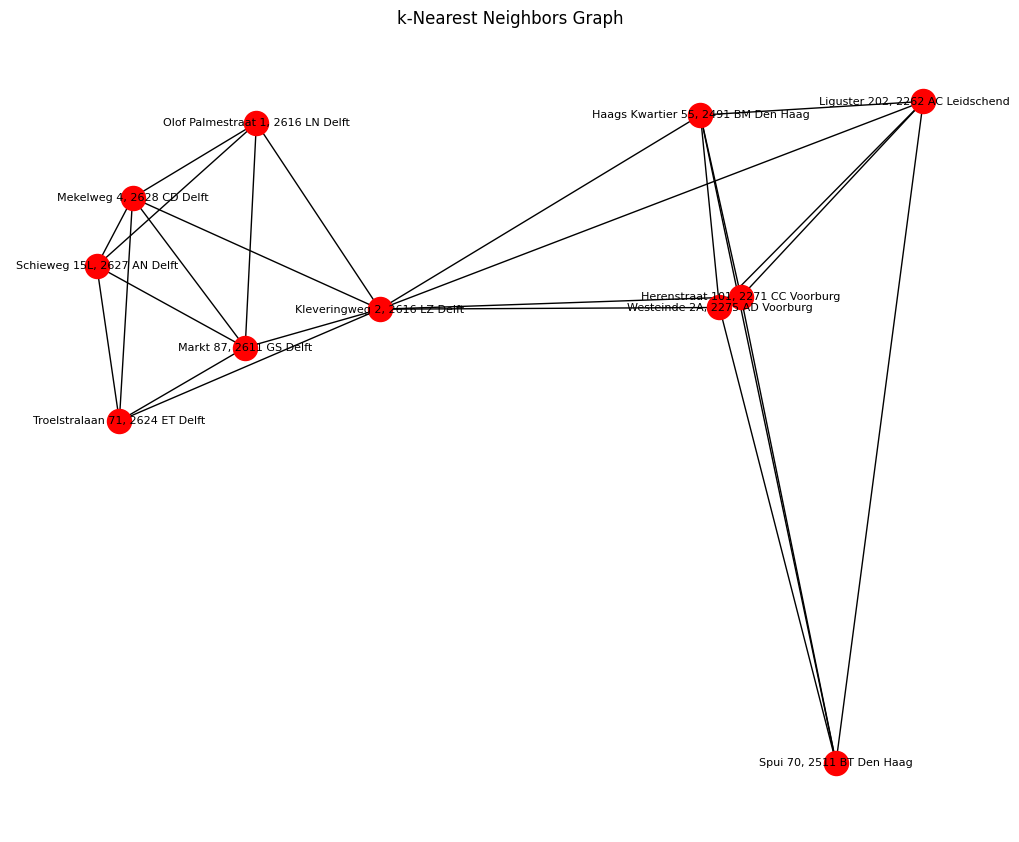

In [73]:
# Build the k-NN graph
k = 4  # Number of neighbors
G = build_knn_graph(coordinates, k)

#G = duplicate_first_node(G)
# Plot the k-NN graph
plot_knn_graph(G)

In [74]:
print(G.nodes[10])

{'address': 'Liguster 202, 2262 AC Leidschendam', 'pos': (52.0877886, 4.3833151)}


In [75]:
# Initialize the directed graph
DG = nx.DiGraph()

# Add nodes and their attributes from the undirected graph to the directed graph
for node, data in G.nodes(data=True):
    if data['address'] != 'Mekelweg 4, 2628 CD Delft':
        DG.add_node(node, **data)


# Add both directions for each edge in the undirected graph
for u, v in G.edges:
    if G.nodes[u]['address'] != 'Mekelweg 4, 2628 CD Delft' and G.nodes[v]['address'] != 'Mekelweg 4, 2628 CD Delft':
        DG.add_edge(u, v)
        DG.add_edge(v, u)

In [76]:
copy_node_data = G.nodes[0]
new_outgoing_node = 'Source'
new_incoming_node = 'Sink'
DG.add_node(new_outgoing_node, **copy_node_data)
DG.add_node(new_incoming_node, **copy_node_data)

# Connect the new outgoing node to all existing nodes with outgoing edges
for node in DG.nodes:
    if node != new_outgoing_node and node != new_incoming_node:
        DG.add_edge(new_outgoing_node, node)

# Connect the new incoming node to all existing nodes with incoming edges
for node in DG.nodes:
    if node != new_outgoing_node and node != new_incoming_node:
        DG.add_edge(node, new_incoming_node)

In [77]:
# Initialize lists for origins and destinations
origins = []
destinations = []

# Iterate through all edges
for edge in DG.edges:
    origin, destination = edge
    origins.append(DG.nodes[origin]['pos'])
    destinations.append(DG.nodes[destination]['pos'])

# Print the lists of origins and destinations
print("Origins:", origins)
print("Destinations:", destinations)
print(len(origins))

Origins: [(52.0115073, 4.358595), (52.0115073, 4.358595), (52.0115073, 4.358595), (52.0115073, 4.358595), (52.0115073, 4.358595), (52.0127665, 4.3811469), (52.0127665, 4.3811469), (52.0127665, 4.3811469), (52.0127665, 4.3811469), (51.9973499, 4.3512313), (51.9973499, 4.3512313), (51.9973499, 4.3512313), (51.9973499, 4.3512313), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (52.0266492, 4.3624455), (51.9948117, 4.3667978), (51.9948117, 4.3667978), (51.9948117, 4.3667978), (51.9948117, 4.3667978), (52.0648646, 4.3626176), (52.0648646, 4.3626176), (52.0648646, 4.3626176), (52.0648646, 4.3626176), (52.0648646, 4.3626176), (52.0648646, 4.3626176), (52.0672856, 4.3636863), (52.0672856, 4.3636863), (52.0672856, 4.3636863), (52.0672856, 4.3636863), (52.0672856, 4.3636863), (52.0672856, 4.3636863), (52.0627222, 4.3819389), (52.0627222, 4.3819389), (52.0627222, 4.38193

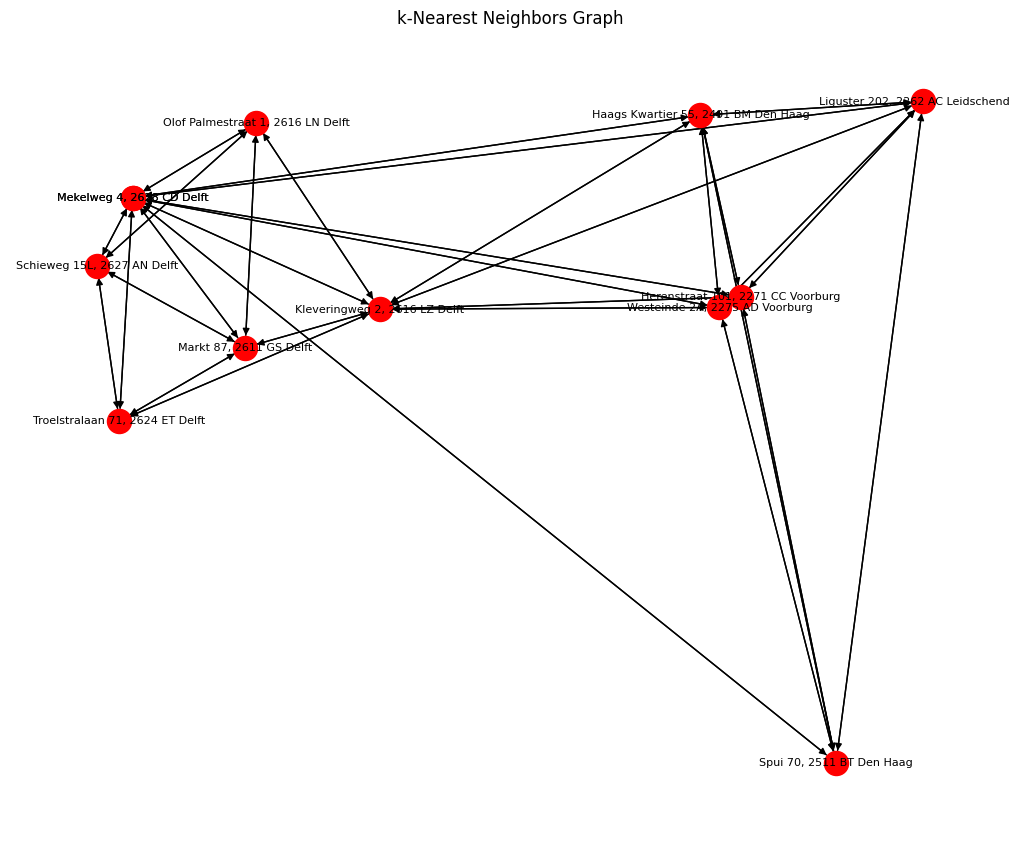

In [78]:
plot_knn_graph(DG)

In [79]:
from google_interface import get_edge_weight

In [80]:
google_distances = get_edge_weight(origins, destinations)

In [81]:
durations = [[trip['driving']['duration'], trip['bicycling']['duration']] for trip in google_distances]
distances = [[trip['driving']['distance'], trip['bicycling']['distance']] for trip in google_distances]

In [82]:
DG_save = DG

In [83]:
DG = DG_save

In [84]:
for node in DG.nodes:
    if node != 'Sink' and node != 'Source':
        DG.nodes[node]['demand'] = 1

i = 0
for u, v in DG.edges():
    DG.edges[u, v]['cost'] = durations[i]
    DG.edges[u, v]['distances'] = distances[i]
    i=i+1

In [85]:
from vrpy import VehicleRoutingProblem

In [158]:
prob = VehicleRoutingProblem(DG, mixed_fleet=True, load_capacity=[5, 5], num_vehicles=[1, 4])#, drop_penalty=0.1)
prob.solve(exact=False,greedy=True,time_limit=10,pricing_strategy='Hyper',dive=True)

INFO:vrpy.vrp:new upper bound : max num stops = 7
INFO:vrpy.vrp:iteration 0, 900000
INFO:vrpy.vrp:iteration 1, 150000
INFO:vrpy.vrp:iteration 2, 125000
INFO:vrpy.vrp:iteration 3, 100000
INFO:vrpy.vrp:iteration 4, 100000
INFO:vrpy.vrp:iteration 5, 100000
INFO:vrpy.vrp:iteration 6, 7563.0
INFO:vrpy.vrp:iteration 7, 7128.0
INFO:vrpy.vrp:iteration 8, 7128.0
INFO:vrpy.vrp:iteration 9, 7128.0
INFO:vrpy.vrp:iteration 10, 7128.0
INFO:vrpy.vrp:iteration 11, 7128.0
INFO:vrpy.vrp:iteration 12, 7128.0
INFO:vrpy.vrp:iteration 13, 7128.0
INFO:vrpy.vrp:iteration 14, 7128.0
INFO:vrpy.vrp:iteration 15, 7128.0
INFO:vrpy.vrp:iteration 16, 7128.0
INFO:vrpy.vrp:iteration 17, 7128.0
INFO:vrpy.vrp:iteration 18, 7128.0
INFO:vrpy.vrp:iteration 19, 7128.0
INFO:vrpy.vrp:iteration 20, 7128.0
INFO:vrpy.vrp:iteration 21, 7058.0
INFO:vrpy.vrp:iteration 22, 6945.0
INFO:vrpy.master_solve_pulp:total cost = 6945.0


In [150]:
print(f"{prob.best_value=}")
print(f"{prob.best_routes=}")
print(f"{prob.best_routes_load=}")
print(f"{prob.best_routes_type=}")

prob.best_value=6945
prob.best_routes={1: ['Source', 9, 8, 10, 7, 6, 'Sink'], 2: ['Source', 5, 3, 1, 4, 2, 'Sink']}
prob.best_routes_load={1: 5, 2: 5}
prob.best_routes_type={1: 0, 2: 1}


In [156]:
import folium

def find_center(route:list[tuple[int]]) -> tuple[int]:
    # Calculate the center of the route
    latitudes = [coord[0] for coord in route]
    longitudes = [coord[1] for coord in route]
    center = (sum(latitudes) / len(route), sum(longitudes) / len(route))
    return center

def render_map(route:list[tuple[int]], outfile:str):
    #map_center = find_center(route)  # Centered on one of the coordinates
    map_center =(52.0115073, 4.358595)
    mymap = folium.Map(location=map_center, zoom_start=13)

    # Add markers for each address
    for address, coord in route:
        folium.Marker(
            location=coord,
            popup=address,
        ).add_to(mymap)

    # Add edges between consecutive addresses
    #addresses_list = list(coordinates.keys())
    addresses_list = route
    for i, (address, coord) in enumerate(route[:-1]):
        coord_1 = coord
        coord_2 = route[i + 1][1]
        # Calculate midpoint between two coordinates for label placement
        midpoint = [(coord_1[0] + coord_2[0]) / 2, (coord_1[1] + coord_2[1]) / 2]
        folium.PolyLine(
            locations=[coord_1, coord_2],
            color="blue",
            popup=f'Edge {i+1}<br><a href="https://www.google.com/maps/dir/?api=1&origin={coord_1[0]},{coord_1[1]}&destination={coord_2[0]},{coord_2[1]}&travelmode=driving" target="_blank">Route to next node</a>',
            tooltip=f"Edge {i+1}",
        ).add_to(mymap)
        folium.Marker(
            location=midpoint,
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt;">{i+1}</div>')
        ).add_to(mymap)

    # Save the map to an HTML file
    mymap.save('route'+outfile+'.html')

In [157]:
for route_id, route in prob.best_routes.items():
    route = [(DG.nodes[node]['address'], DG.nodes[node]['pos']) for node in prob.best_routes[route_id]]
    #vehicle = vehicles[result.best_routes_type[route_id]]
    #name = f"{vehicle.name}_{vehicle.type}_{route_id}.html"
    render_map(route,str(route_id))

In [133]:
# Create coordinates dictionary

coordinates = [(DG.nodes[node]['address'], DG.nodes[node]['pos']) for node in prob.best_routes[1]]

# Print the coordinates dictionary
print("Coordinates:", coordinates)

Coordinates: [('Mekelweg 4, 2628 CD Delft', (51.9988441, 4.3736485)), ('Markt 87, 2611 GS Delft', (52.0115073, 4.358595)), ('Troelstralaan 71, 2624 ET Delft', (51.9973499, 4.3512313)), ('Schieweg 15L, 2627 AN Delft', (51.9948117, 4.3667978)), ('Olof Palmestraat 1, 2616 LN Delft', (52.0127665, 4.3811469)), ('Kleveringweg 2, 2616 LZ Delft', (52.0266492, 4.3624455)), ('Haags Kwartier 55, 2491 BM Den Haag', (52.0627222, 4.3819389)), ('Liguster 202, 2262 AC Leidschendam', (52.0877886, 4.3833151)), ('Herenstraat 101, 2271 CC Voorburg', (52.0672856, 4.3636863)), ('Westeinde 2A, 2275 AD Voorburg', (52.0648646, 4.3626176)), ('Spui 70, 2511 BT Den Haag', (52.0779773, 4.3169084)), ('Mekelweg 4, 2628 CD Delft', (51.9988441, 4.3736485))]


In [144]:
import folium

# Create a map centered around Delft
map_center = (52.0115073, 4.358595)  # Centered on one of the coordinates
mymap = folium.Map(location=map_center, zoom_start=13)

# Add markers for each address
for address, coord in coordinates:
    folium.Marker(
        location=coord,
        popup=address,
    ).add_to(mymap)

# Add edges between consecutive addresses
#addresses_list = list(coordinates.keys())
addresses_list = coordinates
for i, (address, coord) in enumerate(coordinates[:-1]):
    coord_1 = coord
    coord_2 = coordinates[i + 1][1]
    # Calculate midpoint between two coordinates for label placement
    midpoint = [(coord_1[0] + coord_2[0]) / 2, (coord_1[1] + coord_2[1]) / 2]
    folium.PolyLine(
        locations=[coord_1, coord_2],
        color="blue",
        popup=f'Edge {i+1}<br><a href="https://www.google.com/maps/dir/?api=1&origin={coord_1[0]},{coord_1[1]}&destination={coord_2[0]},{coord_2[1]}&travelmode=driving" target="_blank">Route to next node</a>',
        tooltip=f"Edge {i+1}",
    ).add_to(mymap)
    folium.Marker(
        location=midpoint,
        icon=folium.DivIcon(html=f'<div style="font-size: 10pt;">{i+1}</div>')
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("optimesed route.html")